In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.signal as ss

from scipy.optimize import curve_fit

import scipy.constants as c

In [18]:
data = np.loadtxt("test1_1000_H.csv", delimiter=',', skiprows=10)

t_vals = data[:, 0]
V_vals = -data[:, 1]

t_adjusted = t_vals - np.full_like(t_vals, min(t_vals))

t_clipped = t_adjusted[:-58]

# wavelength_A = (t_clipped*1.667 + np.full_like(t_clipped, 650*6)) 

wavelength_nm = np.full_like(t_clipped, 550*6/10-12) + t_clipped*10

#wavelength_nm_clipped = wavelength_nm
V_vals_clipped = V_vals[:-58]

#len(wavelength_nm_clipped)

print((t_clipped))
print(wavelength_nm)


[0.000e+00 2.000e-02 4.000e-02 ... 4.258e+01 4.260e+01 4.262e+01]
[318.  318.2 318.4 ... 743.8 744.  744.2]


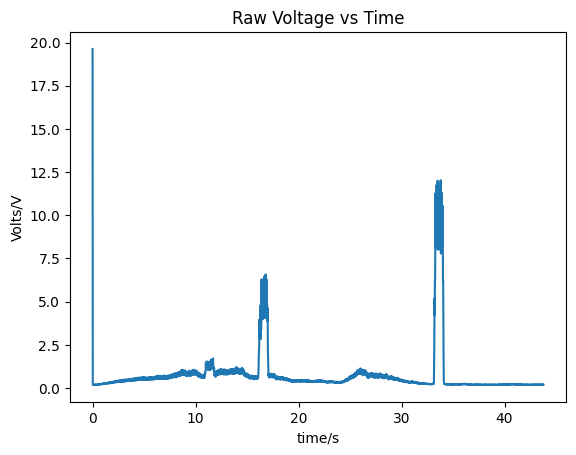

In [19]:
plt.plot(t_adjusted,V_vals)
plt.xlabel('time/s')
plt.ylabel('Volts/V')
plt.title('Raw Voltage vs Time')
plt.show()

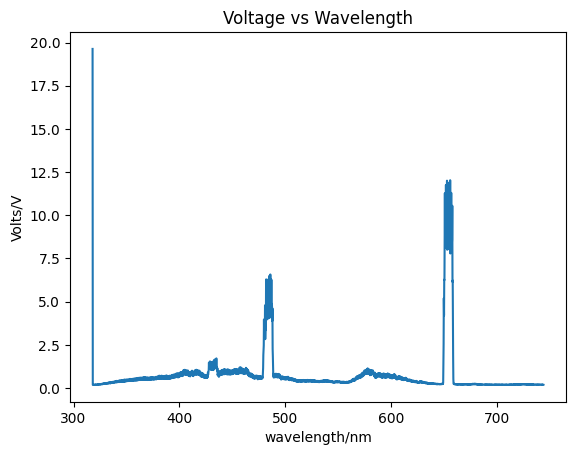

In [20]:
plt.plot(wavelength_nm,V_vals_clipped)
plt.xlabel('wavelength/nm')
plt.ylabel('Volts/V')
plt.title('Voltage vs Wavelength')
plt.show()

# Smoothed Data

In [21]:
def moving_average(data, smooth_interval=2):

    if(smooth_interval > len(data)):
        print("Smooth interval > lenght of data")
        return
    
    sum = 0
    new_data = np.zeros(len(data))

    for i in range (smooth_interval):
        for j in range(smooth_interval):
            sum += data[i+j]
        average = sum/smooth_interval
        new_data[i] = average
        sum = 0

    for i in range(len(data)-smooth_interval):
        for j in range(smooth_interval):
            sum += data[i+j]
        average = sum/smooth_interval
        new_data[i+smooth_interval] = average
        sum = 0
    return new_data

2122
2122


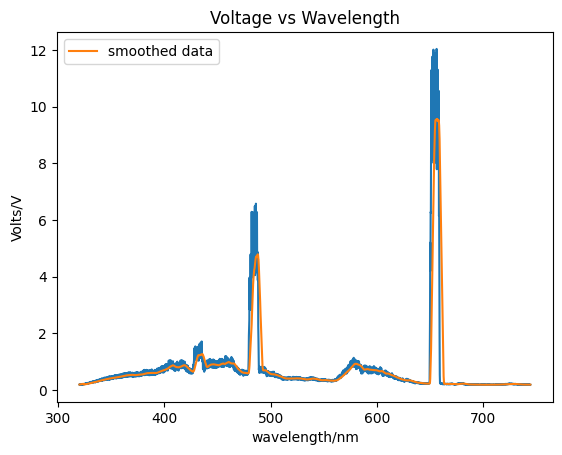

In [28]:
wavelength_nm_clipped = wavelength_nm[10:]
V_vals_clipped1 = V_vals_clipped[10:]

window_size = 20

V_vals_smooth = moving_average(V_vals_clipped1, window_size)

print(len(V_vals_smooth))
print(len(wavelength_nm_clipped))

plt.plot(wavelength_nm_clipped,V_vals_clipped1)
plt.plot(wavelength_nm_clipped,V_vals_smooth, label="smoothed data")
# colors = np.array(['m','c','r'])
# for i in range(len(peak_vals)):
#     plt.scatter(peak_vals[i], V_peak_vals[i], c=colors[i], label=f"{peak_vals[i]:.2f}nm")
plt.xlabel('wavelength/nm')
plt.ylabel('Volts/V')
plt.title('Voltage vs Wavelength')
plt.legend()
plt.show()

3


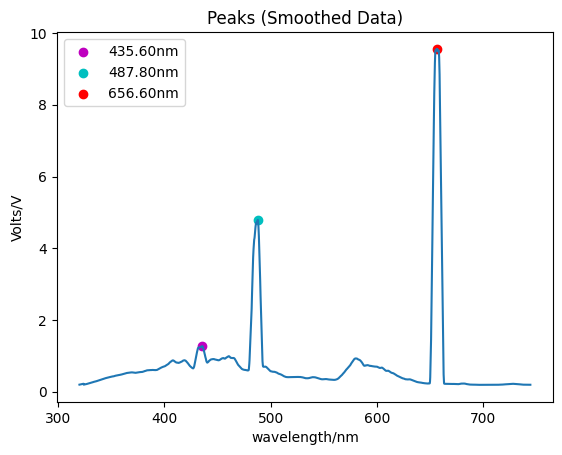

In [30]:
wavelength_nm_clipped = wavelength_nm[10:]
V_vals_clipped1 = V_vals_clipped[10:]

peak_idx, _ = ss.find_peaks(V_vals_smooth, height=1.2, width=4)

peak_vals = []
V_peak_vals = []

for idx in peak_idx:

    peak_vals.append(wavelength_nm_clipped[int(idx)])
    V_peak_vals.append(V_vals_smooth[int(idx)])

print(len(peak_vals))


plt.plot(wavelength_nm_clipped,V_vals_smooth)
colors = np.array(['m','c','r'])
for i in range(len(peak_vals)):
    plt.scatter(peak_vals[i], V_peak_vals[i], c=colors[i], label=f"{peak_vals[i]:.2f}nm")
plt.xlabel('wavelength/nm')
plt.ylabel('Volts/V')
plt.title('Peaks (Smoothed Data)')
plt.legend()
plt.show()

# Error Analysis

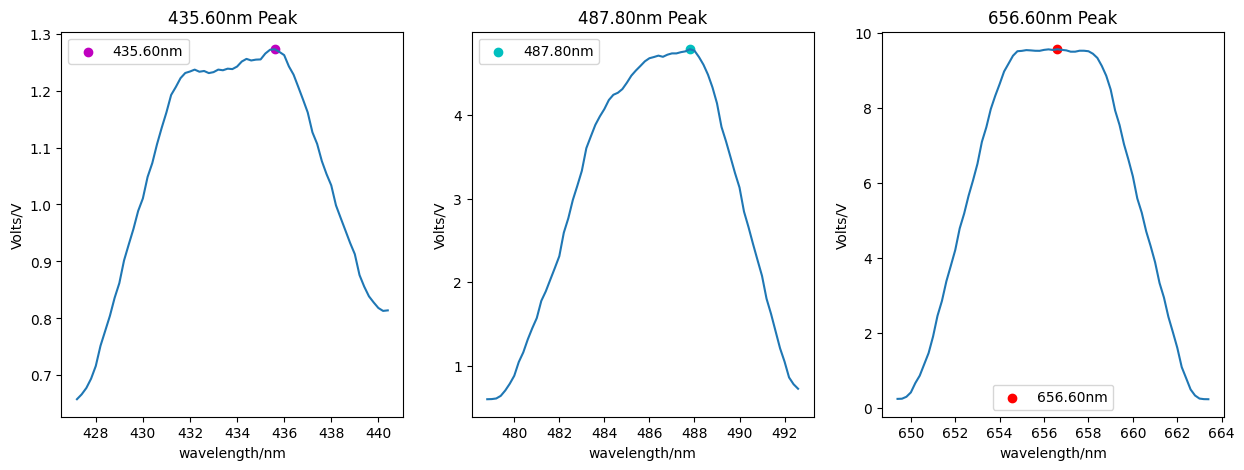

In [69]:
peak_435 = wavelength_nm_clipped[peak_idx[0]-42:peak_idx[0]+25]
V_435 = V_vals_smooth[peak_idx[0]-42:peak_idx[0]+25]

peak_486 = wavelength_nm_clipped[peak_idx[1]-45:peak_idx[1]+25]
V_486 = V_vals_smooth[peak_idx[1]-45:peak_idx[1]+25]

peak_656 = wavelength_nm_clipped[peak_idx[2]-36:peak_idx[2]+35]
V_656 = V_vals_smooth[peak_idx[2]-36:peak_idx[2]+35]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

ax1.plot(peak_435,V_435)
ax1.scatter(peak_vals[0], V_peak_vals[0], c=colors[0], label=f"{peak_vals[0]:.2f}nm")
ax1.set_xlabel('wavelength/nm')
ax1.set_ylabel('Volts/V')
ax1.set_title(f'{peak_vals[0]:.2f}nm Peak')
ax1.legend()

ax2.plot(peak_486,V_486)
ax2.scatter(peak_vals[1], V_peak_vals[1], c=colors[1], label=f"{peak_vals[1]:.2f}nm")
ax2.set_xlabel('wavelength/nm')
ax2.set_ylabel('Volts/V')
ax2.set_title(f'{peak_vals[1]:.2f}nm Peak')
ax2.legend()

ax3.plot(peak_656,V_656)
ax3.scatter(peak_vals[2], V_peak_vals[2], c=colors[2], label=f"{peak_vals[2]:.2f}nm")
ax3.set_xlabel('wavelength/nm')
ax3.set_ylabel('Volts/V')
ax3.set_title(f'{peak_vals[2]:.2f}nm Peak')
ax3.legend()

plt.show()

## Lorenztian Fitting

In [70]:
def lorentzian(x, amplitude, center_x, fwhm, baseline):
    """
     Lorentzian function definition.
     amplitude: peak amplitude
     center_x: center of the peak
     fwhm: Full Width at Half Maximum
     baseline: constant baseline offset
    """
    gamma = fwhm / 2.0
    return baseline + amplitude * (gamma**2 / ((x - center_x)**2 + gamma**2))



def fit_lorenztian(x_data, y_data, p0=None):

    """
    Returns fit amplitude, center, FWHM and baseline along with an array of their errors
    """

    # Initial guesses for a, x0, gam, c (amplitude, center_x, fwhm, baseline)
    if p0 == None:
        p0_guesses = [max(x_data), x_data[np.argmax(y_data)], 1.0, min(y_data)]
    else:
        p0_guesses = p0

    # Perform the curve fit
    popt, pcov = curve_fit(lorentzian, x_data, y_data, p0=p0_guesses)

    # popt contains the optimized parameters
    fit_amplitude, fit_center_x, fit_fwhm, fit_baseline = popt

    # pcov contains fit errors
    p_err_arr = np.sqrt(np.diag(pcov))

    return fit_amplitude, fit_center_x, fit_fwhm, fit_baseline, p_err_arr

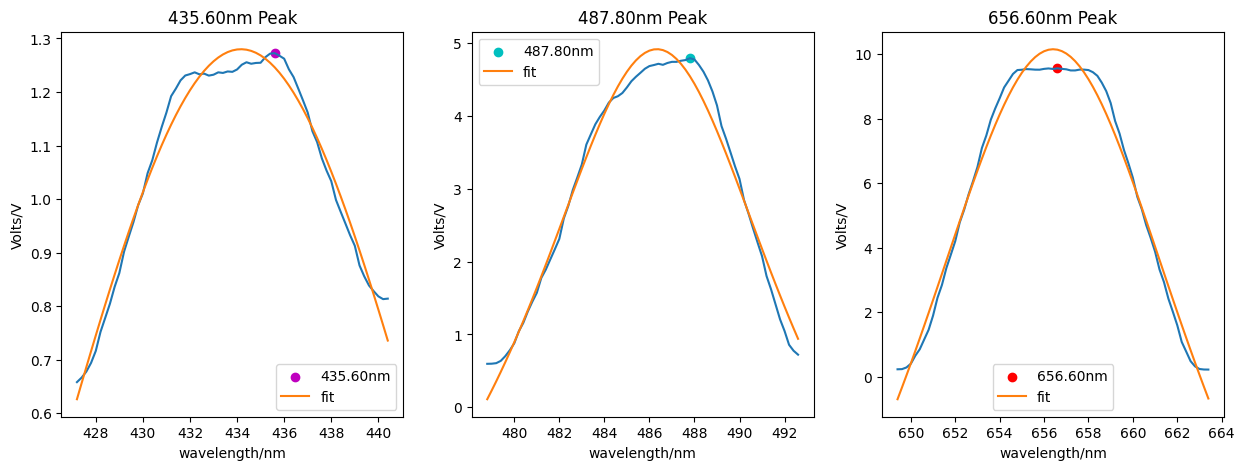

In [73]:
fit_435 = fit_lorenztian(peak_435, V_435)
fitted_V_435 = lorentzian(peak_435, fit_435[0], fit_435[1], fit_435[2], fit_435[3])

fit_486 = fit_lorenztian(peak_486, V_486)
fitted_V_486 = lorentzian(peak_486, fit_486[0], fit_486[1], fit_486[2], fit_486[3])

fit_656 = fit_lorenztian(peak_656, V_656)
fitted_V_656 = lorentzian(peak_656, fit_656[0], fit_656[1], fit_656[2], fit_656[3])


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

ax1.plot(peak_435,V_435)
ax1.scatter(peak_vals[0], V_peak_vals[0], c=colors[0], label=f"{peak_vals[0]:.2f}nm")
ax1.plot(peak_435, fitted_V_435, label='fit')
ax1.set_xlabel('wavelength/nm')
ax1.set_ylabel('Volts/V')
ax1.set_title(f'{peak_vals[0]:.2f}nm Peak')
ax1.legend()

ax2.plot(peak_486,V_486)
ax2.scatter(peak_vals[1], V_peak_vals[1], c=colors[1], label=f"{peak_vals[1]:.2f}nm")
ax2.plot(peak_486, fitted_V_486, label='fit')
ax2.set_xlabel('wavelength/nm')
ax2.set_ylabel('Volts/V')
ax2.set_title(f'{peak_vals[1]:.2f}nm Peak')
ax2.legend()

ax3.plot(peak_656,V_656)
ax3.scatter(peak_vals[2], V_peak_vals[2], c=colors[2], label=f"{peak_vals[2]:.2f}nm")
ax3.plot(peak_656, fitted_V_656, label='fit')
ax3.set_xlabel('wavelength/nm')
ax3.set_ylabel('Volts/V')
ax3.set_title(f'{peak_vals[2]:.2f}nm Peak')
ax3.legend()

plt.show()

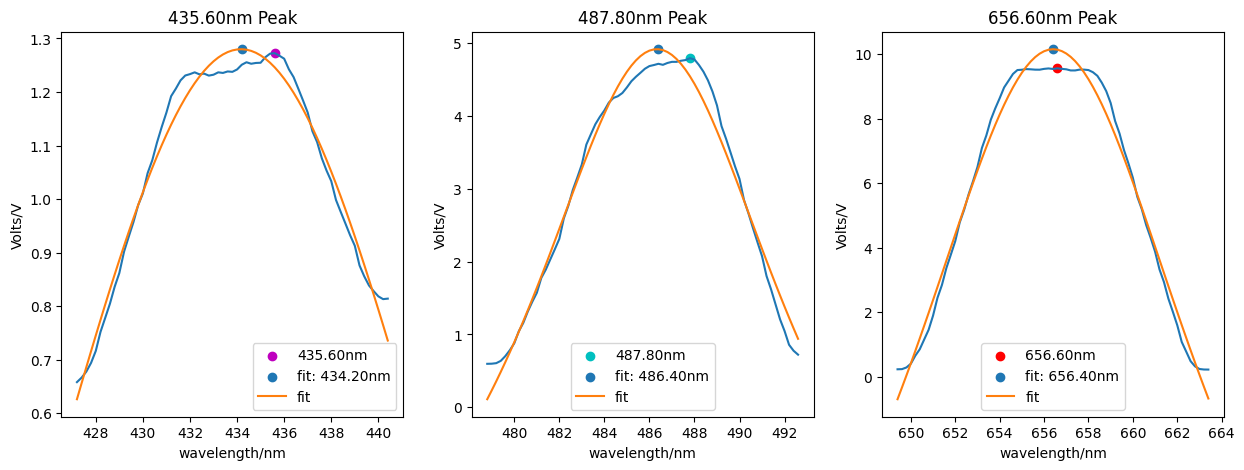

In [84]:
peak_435_idx, _ = ss.find_peaks(fitted_V_435, height=1.2, width=4)
peak_486_idx, _ = ss.find_peaks(fitted_V_486, height=1.2, width=4)
peak_656_idx, _ = ss.find_peaks(fitted_V_656, height=1.2, width=4)


peak_435_idx = peak_435_idx.item()
peak_486_idx = peak_486_idx.item()
peak_656_idx = peak_656_idx.item()

fitted_peak_vals = np.array([peak_435[peak_435_idx], peak_486[peak_486_idx], peak_656[peak_656_idx]])


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,5))

ax1.plot(peak_435,V_435)
ax1.scatter(peak_vals[0], V_peak_vals[0], c=colors[0], label=f"{peak_vals[0]:.2f}nm")
ax1.scatter(peak_435[peak_435_idx], fitted_V_435[peak_435_idx], label=f"fit: {peak_435[peak_435_idx]:.2f}nm")
ax1.plot(peak_435, fitted_V_435, label='fit')
ax1.set_xlabel('wavelength/nm')
ax1.set_ylabel('Volts/V')
ax1.set_title(f'{peak_vals[0]:.2f}nm Peak')
ax1.legend()

ax2.plot(peak_486,V_486)
ax2.scatter(peak_vals[1], V_peak_vals[1], c=colors[1], label=f"{peak_vals[1]:.2f}nm")
ax2.scatter(peak_486[peak_486_idx], fitted_V_486[peak_486_idx], label=f"fit: {peak_486[peak_486_idx]:.2f}nm")
ax2.plot(peak_486, fitted_V_486, label='fit')
ax2.set_xlabel('wavelength/nm')
ax2.set_ylabel('Volts/V')
ax2.set_title(f'{peak_vals[1]:.2f}nm Peak')
ax2.legend()

ax3.plot(peak_656,V_656)
ax3.scatter(peak_vals[2], V_peak_vals[2], c=colors[2], label=f"{peak_vals[2]:.2f}nm")
ax3.scatter(peak_656[peak_656_idx], fitted_V_656[peak_656_idx], label=f"fit: {peak_656[peak_656_idx]:.2f}nm")
ax3.plot(peak_656, fitted_V_656, label='fit')
ax3.set_xlabel('wavelength/nm')
ax3.set_ylabel('Volts/V')
ax3.set_title(f'{peak_vals[2]:.2f}nm Peak')
ax3.legend()

plt.show()


# Balmer Series

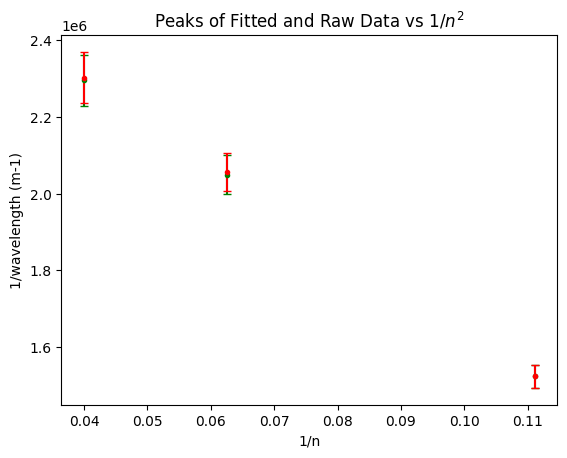

In [86]:
one_over_n_squared = np.array([1/5**2, 1/4**2, 1/3**2])

errors = np.array([0.067, 0.05, 0.03])*1e6

plt.errorbar(one_over_n_squared, 1/(np.array(peak_vals)*1e-9), yerr=errors, fmt='g.', capsize=3)
plt.errorbar(one_over_n_squared, 1/(np.array(fitted_peak_vals)*1e-9), yerr=errors, fmt='r.', capsize=3, label='fitted peaks')
plt.ylabel('1/wavelength (m-1)')
plt.xlabel('1/n')
plt.title(r'Peaks of Fitted and Raw Data vs $1/n^2$')
plt.show()

In [87]:
def rydberg(x, m, c):

    return m*x + c


y_data = 1/(np.array(fitted_peak_vals) * 1e-9)
x_data = np.array([1/5**2, 1/4**2, 1/3**2])

popt, pcov = curve_fit(rydberg, x_data, y_data)

m = popt[0]
c1 = popt[1]

m_err = np.sqrt(np.diag(pcov)[0])
c_err = np.sqrt(np.diag(pcov)[1])

print(f'm = {m:.3e} pm {m_err:.3e}')
print(f'c = {c1:.3e} pm {c_err:.3e}')

m = -1.096e+07 pm 7.566e+03
c = 2.741e+06 pm 5.837e+02


In [88]:
R_from_m = - m
R_from_c =  4 * c1

print(f'R from m = {R_from_m:.3e} pm {m_err:.3e} m-1')
print(f'R from c = {R_from_c:.3e} pm {c_err*4:.3e} m-1')
print(f'actual R = {10973731.6:.3e} m-1')


R from m = 1.096e+07 pm 7.566e+03 m-1
R from c = 1.097e+07 pm 2.335e+03 m-1
actual R = 1.097e+07 m-1


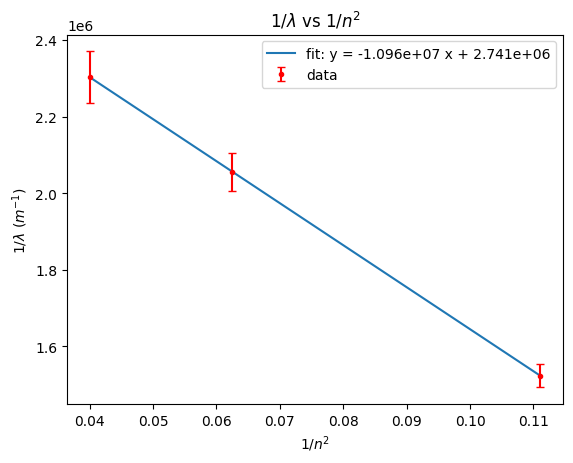

In [89]:
nvals = np.linspace(min(x_data), max(x_data))

y_fit = rydberg(nvals, m, c1)

plt.errorbar(one_over_n_squared, 1/(np.array(fitted_peak_vals)*1e-9), yerr=errors, fmt='r.', capsize=3, label='data')
plt.plot(nvals, y_fit, label=f'fit: y = {m:.3e} x + {c1:.3e}')
plt.ylabel(r'$1/\lambda$ ($m^{-1}$)')
plt.xlabel(r'$1/n^2$')
plt.title(r'$1/\lambda$ vs $1/n^2$')
plt.legend()
plt.show()